In [2]:
import itertools
import os
import pickle

import ffsim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lucj_ffsim.lucj import LUCJTask

In [3]:
MOL_DATA_DIR = "data/molecular_data"
DATA_DIR = "data/lucj"
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)


basis = "sto-6g"
ne, norb = 4, 4
molecule_basename = f"ethene_dissociation_{basis}_{ne}e{norb}o"

reference_curves_bond_distance_range = np.linspace(1.3, 4.0, 50)
bond_distance_range = np.linspace(1.3, 4.0, 6)
# bond_distance_range = np.linspace(1.3, 4.0, 50)
connectivities = [
    "all-to-all",
    "square",
    "hex",
    "heavy-hex",
]
n_reps_range = [
    2,
    4,
    6,
]
with_final_orbital_rotation_choices = [False]
param_initialization_methods = ["ccsd"]
optimization_methods = [
    "L-BFGS-B",
    "linear-method",
]

ansatz_settings = list(
    itertools.product(
        connectivities,
        n_reps_range,
        with_final_orbital_rotation_choices,
        param_initialization_methods,
        optimization_methods,
    )
)
n_pts = len(bond_distance_range)

In [4]:
mol_datas_reference: dict[float, ffsim.MolecularData] = {}
mol_datas_experiment: dict[float, ffsim.MolecularData] = {}

for bond_distance in reference_curves_bond_distance_range:
    filename = os.path.join(
        MOL_DATA_DIR, f"{molecule_basename}_bond_distance_{bond_distance:.5f}.pickle"
    )
    with open(filename, "rb") as f:
        mol_data = pickle.load(f)
        mol_datas_reference[bond_distance] = mol_data

for bond_distance in bond_distance_range:
    filename = os.path.join(
        MOL_DATA_DIR, f"{molecule_basename}_bond_distance_{bond_distance:.5f}.pickle"
    )
    with open(filename, "rb") as f:
        mol_data = pickle.load(f)
        mol_datas_experiment[bond_distance] = mol_data

hf_energies_reference = np.array(
    [mol_data.hf_energy for mol_data in mol_datas_reference.values()]
)
fci_energies_reference = np.array(
    [mol_data.fci_energy for mol_data in mol_datas_reference.values()]
)
hf_energies_experiment = np.array(
    [mol_data.hf_energy for mol_data in mol_datas_experiment.values()]
)
fci_energies_experiment = np.array(
    [mol_data.fci_energy for mol_data in mol_datas_experiment.values()]
)

In [5]:
data = {}
for (
    connectivity,
    n_reps,
    with_final_orbital_rotation,
    param_initialization,
    optimization_method,
) in ansatz_settings:
    for bond_distance in bond_distance_range:
        task = LUCJTask(
            molecule_basename=f"{molecule_basename}_bond_distance_{bond_distance:.5f}",
            connectivity=connectivity,
            n_reps=n_reps,
            with_final_orbital_rotation=with_final_orbital_rotation,
            param_initialization=param_initialization,
            optimization_method=optimization_method,
        )
        filename = os.path.join(DATA_DIR, task.dirname, "data.pickle")
        with open(filename, "rb") as f:
            data[
                (
                    bond_distance,
                    connectivity,
                    n_reps,
                    with_final_orbital_rotation,
                    param_initialization,
                    optimization_method,
                )
            ] = pickle.load(f)


keys = ["energy", "error", "spin_squared", "nit", "nfev", "nlinop"]
data = pd.DataFrame(
    list(
        zip(
            data.keys(),
            *zip(*[[d[k] for k in keys] for d in data.values()]),
        )
    ),
    columns=["key"] + keys,
)
data.set_index(
    pd.MultiIndex.from_tuples(
        data["key"],
        names=[
            "bond_distance",
            "connectivity",
            "n_reps",
            "with_final_orbital_rotation",
            "param_initialization",
            "optimization_method",
        ],
    ),
    inplace=True,
)
data.drop(columns="key", inplace=True)  # Drop the original 'Key' column

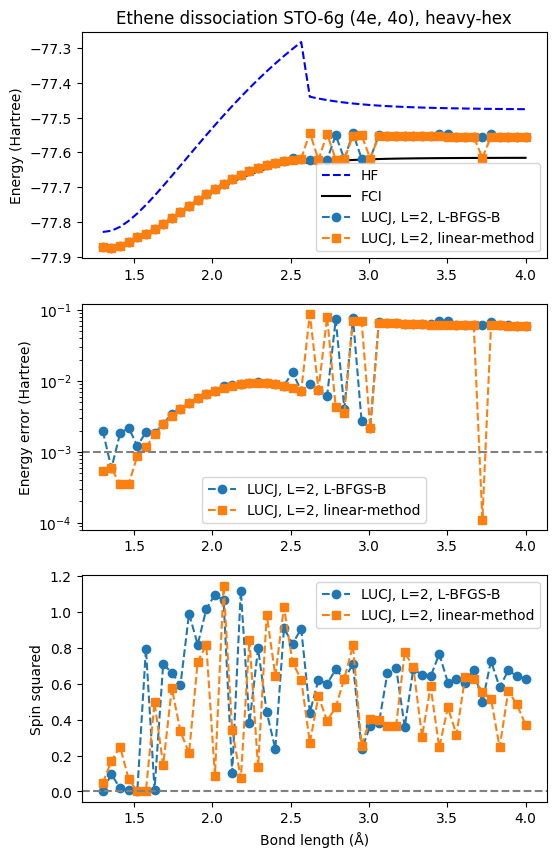

<Figure size 640x480 with 0 Axes>

In [10]:
# effect of optimization method

markers = ["o", "s", "v", "D", "p", "*"]
connectivity = "heavy-hex"
n_reps = 2

filename = (
    f"{molecule_basename}_npts-{n_pts}_opt" + f"_{connectivity}" + f"_n_reps-{n_reps}"
)

this_data = {}
for optimization_method in optimization_methods:
    settings = {
        "connectivity": connectivity,
        "n_reps": n_reps,
        "with_final_orbital_rotation": False,
        "param_initialization": "ccsd",
        "optimization_method": optimization_method,
    }
    this_data[optimization_method] = data.xs(
        tuple(settings.values()), level=tuple(settings.keys())
    )


fig, (ax, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 10))
fig.subplots_adjust(wspace=0.25)

ax.plot(
    reference_curves_bond_distance_range,
    hf_energies_reference,
    "--",
    label="HF",
    color="blue",
)
ax.plot(
    reference_curves_bond_distance_range,
    fci_energies_reference,
    "-",
    label="FCI",
    color="black",
)
for optimization_method, marker in zip(optimization_methods, markers):
    ax.plot(
        bond_distance_range,
        this_data[optimization_method]["energy"].values,
        f"{marker}--",
        label=f"LUCJ, L={n_reps}, {optimization_method}",
    )
ax.legend()
ax.set_ylabel("Energy (Hartree)")

for optimization_method, marker in zip(optimization_methods, markers):
    ax2.plot(
        bond_distance_range,
        this_data[optimization_method]["error"].values,
        f"{marker}--",
        label=f"LUCJ, L={n_reps}, {optimization_method}",
    )
ax2.set_yscale("log")
ax2.axhline(1e-3, linestyle="--", color="gray")
ax2.legend()
ax2.set_ylabel("Energy error (Hartree)")

for optimization_method, marker in zip(optimization_methods, markers):
    ax3.plot(
        bond_distance_range,
        this_data[optimization_method]["spin_squared"].values,
        f"{marker}--",
        label=f"LUCJ, L={n_reps}, {optimization_method}",
    )
ax3.axhline(0, linestyle="--", color="gray")
ax3.legend()
ax3.set_ylabel("Spin squared")
ax3.set_xlabel("Bond length (Å)")

ax.set_title(r"Ethene dissociation STO-6g (4e, 4o)" + f", {connectivity}")

plt.show()
plt.savefig(f"{PLOTS_DIR}/{filename}.svg")
# plt.close()

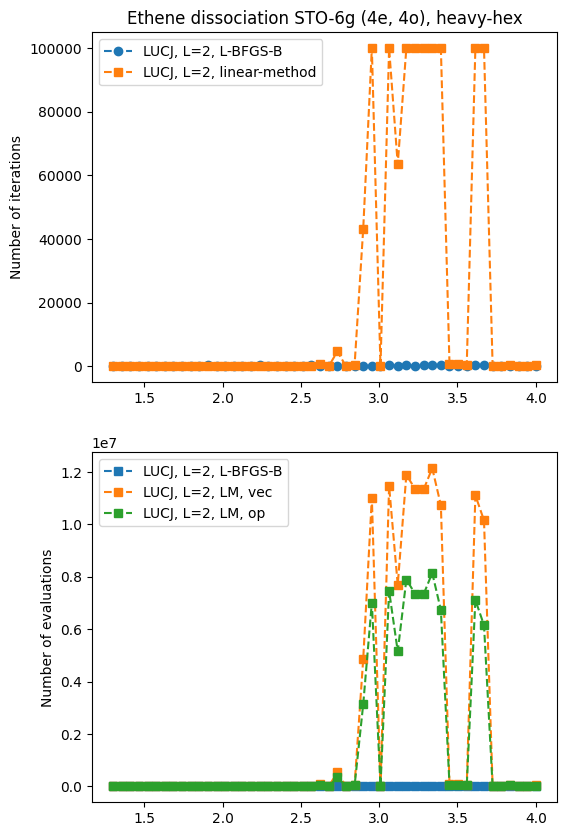

In [9]:
# compare cost of optimization methods

markers = ["o", "s", "v", "D", "p", "*"]
connectivity = "heavy-hex"
n_reps = 2

filename = f"{molecule_basename}" + f"_{connectivity}" + f"_n_reps-{n_reps}"

this_data = {}
for optimization_method in optimization_methods:
    settings = {
        "connectivity": connectivity,
        "n_reps": n_reps,
        "with_final_orbital_rotation": False,
        "param_initialization": "ccsd",
        "optimization_method": optimization_method,
    }
    this_data[optimization_method] = data.xs(
        tuple(settings.values()), level=tuple(settings.keys())
    )


fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 10))
fig.subplots_adjust(wspace=0.25)

for optimization_method, marker in zip(optimization_methods, markers):
    ax.plot(
        bond_distance_range,
        this_data[optimization_method]["nit"].values,
        f"{marker}--",
        label=f"LUCJ, L={n_reps}, {optimization_method}",
    )
ax.legend()
ax.set_ylabel("Number of iterations")

ax2.plot(
    bond_distance_range,
    this_data["L-BFGS-B"]["nfev"].values,
    f"{marker}--",
    label=f"LUCJ, L={n_reps}, L-BFGS-B",
)
ax2.plot(
    bond_distance_range,
    this_data["linear-method"]["nfev"].values,
    f"{marker}--",
    label=f"LUCJ, L={n_reps}, LM, vec",
)
ax2.plot(
    bond_distance_range,
    this_data["linear-method"]["nlinop"].values,
    f"{marker}--",
    label=f"LUCJ, L={n_reps}, LM, op",
)
ax2.legend()
ax2.set_ylabel("Number of evaluations")

ax.set_title(r"Ethene dissociation STO-6g (4e, 4o)" + f", {connectivity}")

plt.show()
# plt.savefig(f"{PLOTS_DIR}/{filename}.svg")
# plt.close()